In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy.linalg import solve_discrete_are

Pendulum Physical Parameters

In [2]:
dt = 0.001 # timestep [s] 

# Mechanical Parameters
m1 = 0.1975 # pendulum arm mass
m2 = 0.2545 # motor rotor and reaction mass kg
L1 = 0.06   # pendulum Arm center of mass distance to axis
L2 = 0.088  # motor center of mass distance to axis
g = 9.81    # gravitational acceleration
R = 0.0655  # wheel radius

I1 = m1 * L1**2 / 12 # pendulum inertia with respect to CoG
I2 = m2 * R**2 / 2   # wheel inertia with respect to CoG

b_p = 0.007 # pendulum arm axis viscous friction
b_m = 0.0  # motor friction

# Motor Parameters
Vmax = 12 # maximal voltage
Ke = 0.29 # Motor EMF constant
Kt = 0.29 # Motor Torque constant

Rm = 22 # motor coil resistance
Lm = 0.01 # motor induction

Nonlinear model

In [3]:
# Build the model with eq. 10

# constants
a = m1 * L1**2 + m2 * L2**2 + I1
b = (m1*L1 + m2*L2)*g

# function that describes nonlinear dynamics
def nonlinear_dynamics(theta, d_theta, d_phi, voltage):
    # Input:
    #   theta - pendulum angle [rad]
    #   d_theta - pendulum angular velocity [rad/s]
    #   d_phi - wheel angular velocity [rad/s]
    #   voltage - motor input voltage [volt]
    
    _dd_theta = b*np.sin(theta)/a - b_p*d_theta/a + (Rm*b_m + Kt*Ke)*d_phi/(a*Rm) - (Kt*voltage)/(a*Rm)
    _dd_phi = -b*np.sin(theta)/a + b_p * d_theta / a - (a + I2)*(b_m + Kt*Ke/Rm)*d_phi/(I2 * a) - (a + I2) * Kt * voltage / (I2 * a * Rm)

    _theta = theta + d_theta * dt
    _d_theta = d_theta + _dd_theta * dt
    _d_phi = d_phi + _dd_phi * dt
    

    return np.array([_theta, _d_theta, _d_phi])

Nonlinear Model Simulation

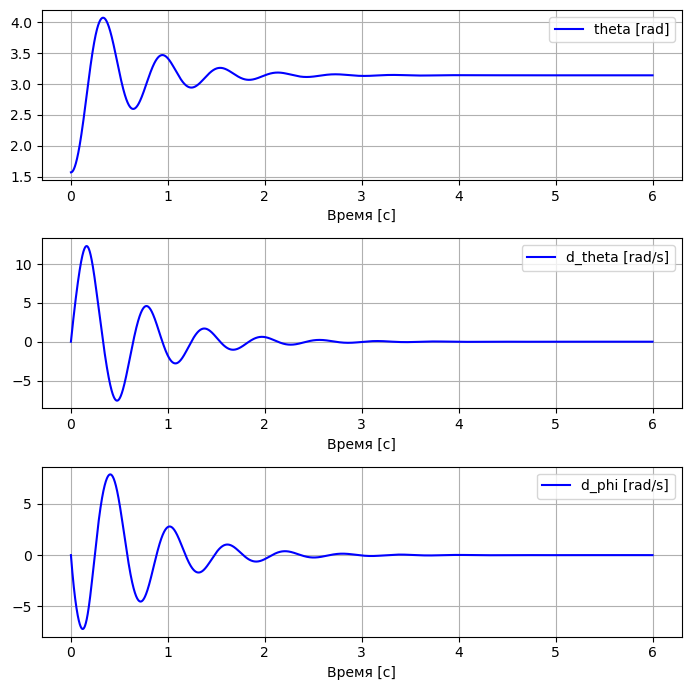

In [4]:
t0 = 0 # start time [s] 
t1 = 6 # stop time [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
T = np.linspace(t0, t1, nt)

x0 = np.array([1.57, 0, 0]) #pend angle, pend angular vel, wheel angle, wheel ang vel
u = 0.0 # voltage [V]

X = [x0]
U = [u]

x_cur = x0.copy()

for t in T[:-1]:
    x_next = nonlinear_dynamics(x_cur[0], x_cur[1], x_cur[2], u)

    X.append(x_next)
    U.append(u)

    x_cur = x_next.copy()

X = np.array(X)
U = np.array(U)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]


# Visualization 

plt.figure(figsize=(7, 7))

plt.subplot(3, 1, 1) 
plt.plot(T, x1, 'blue') 
plt.grid() 
plt.legend(labels=('theta [rad]',))
plt.xlabel("Время [с]")

plt.subplot(3, 1, 2) 
plt.plot(T, x2, 'blue') 
plt.grid() 
plt.legend(labels=('d_theta [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(3, 1, 3) 
plt.plot(T, x3, 'blue') 
plt.grid() 
plt.legend(labels=('d_phi [rad/s]',))
plt.xlabel("Время [с]")


plt.tight_layout()
plt.show()

# Exercises:
# Question: Why do we see such behaviour?
# Try to play with initial state and control input in order to better understand the behaviour

State Space Model

In [5]:
# Create State Space Matrices with eq. (12)

# constants
a = m1 * L1**2 + m2 * L2**2 + I1
b = (m1*L1 + m2*L2)*g

# elements of matrix A and vector B
a21 = b/a
a22 = -b_p/a
a24 = (Rm*b_m + Kt*Ke)/(a*Rm)

a41 = -b/a
a42 = b_p/a
a44 = -(a + I2)*(b_m + Kt*Ke/Rm)/(I2 * a)

b2 = -Kt/(a*Rm)
b4 = -((a + I2)/(a*I2)) * (Kt/Rm)

# State transition matrix A and control vector B
A = np.array([  [0,   1,   0],
                [a21, a22, a24],
                [a41, a42, a44]])

B = np.array([  [0],
                [b2],
                [b4]])

# Output matrices and vectors
C = np.array([  [1, 0, 0],    # pend angle
                [0, 1, 0],    # pend angular vel
                [0, 0, 1],    # wheel speed 
                ])

D = np.array([[0],[0],[0]])

# Create continuous state space model via Control Systems Library
sys = ct.ss(A, B, C, D)

State Space Model Simulation 

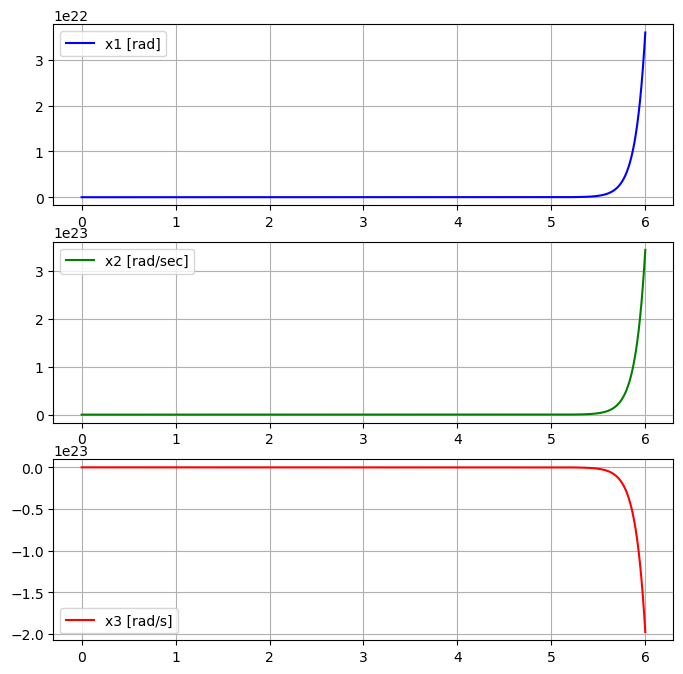

In [6]:
t0 = 0 # [s] 
t1 = 6.0 # [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
t = np.linspace(t0, t1, nt)

x0 = np.array([0.01, 0, 0]) # pend angle [rad], pend angular vel [rad/sec], wheel angle [rad], wheel speed [rad/s]
u = 5 * np.ones(nt) # voltage [V]

# t_, yout = ct.forced_response(sys, t, u, x0)
t_, yout = ct.initial_response(sys, t, x0)

# Visualization 

x1 = yout[0, :]
x2 = yout[1, :]
x3 = yout[2, :]

plt.figure(1, figsize=(8, 8))

plt.subplot(3, 1, 1) 
plt.plot(t, x1, 'blue') 
plt.grid() 
plt.legend(labels=('x1 [rad]',))

plt.subplot(3, 1, 2) 
plt.plot(t, x2, 'green') 
plt.grid() 
plt.legend(labels=('x2 [rad/sec]',))

plt.subplot(3, 1, 3) 
plt.plot(t, x3, 'red') 
plt.grid() 
plt.legend(labels=('x3 [rad/s]',))

# Exercises:
# Question: Why does this plot go to infinity?
# Try to play with initial state and control input using forced response

Convert to Discrete Time Domain

In [7]:
sysd = ct.c2d(sys, dt)
Ad = sysd.A
Bd = sysd.B

# print(Ad)
# print(Bd)
# print("===")

# Ad = np.eye(3) + A * dt
# Bd = B * dt

# print(Ad)
# print(Bd)

# Exercises:
# Write your own code that converts model from continuous to discrete time domain using eq. 13

In [17]:
Bd

array([[-2.40916908e-06],
       [-4.82303776e-03],
       [-2.88391993e-02]])

Controllability Analysis

In [8]:
# Build controllability matrix
n = A.shape[0]
Y = B
for i in range(1, n):
    Y = np.hstack((Y, np.linalg.matrix_power(A, i) @ B))

# Compute the rank of the controllability matrix
rank = np.linalg.matrix_rank(Y)

print("Controllability matrix:\n", Y)
print("Rank of controllability matrix:", rank)

if rank == n:
    print("✅ The system is controllable")
else:
    print("❌ The system is not controllable")


Controllability matrix:
 [[    0.            -4.80895546   -28.09896871]
 [   -4.80895546   -28.09896871  -195.70373173]
 [  -28.95438446   230.84261862 -1420.69654522]]
Rank of controllability matrix: 3
✅ The system is controllable


Stabilization in upright position via LQR Control

In [9]:
# Cost function weight parameters
Q = np.array([  [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1],
                ])
R = np.array([2])

# Solve the problem

# simple way
K, sys, E = ct.dlqr(Ad, Bd, Q, R)

print("K Gains:")
print(K[0])

# solve by hands
# Solve discrete time algebraic Riccati equation (DARE)
# P = solve_discrete_are(Ad, Bd, Q, R)
# Calculate gains
# K = np.linalg.inv(Bd.T @ P @ Bd + R) @ (Bd.T @ P @ Ad)

# Exercise:
# Для решения задачи LQR использована функция dlqr библиотеки Control Toolbox. В библиотеке scipy есть функция solve_discrete_are, решающая уравнения Риккати.
# Напиши свой собственный код, который бы вычислял матрицу K по уравнению (16), используя библиотечную функцию solve_discrete_are.

K Gains:
[-64.41115585  -5.160763    -0.32529951]


Stability Analysis

In [10]:
# The system is said to be asymptotically stable if all eigenvalues of the closed-loop matrix A_cl = A - BK
# lie strictly inside the unit circle in the complex plane

eigvals = np.linalg.eigvals(Ad - Bd @ K)

print("Eigenvalues of closed-loop system:", eigvals)
if np.all(np.abs(eigvals) < 1):
    print("System is asympthotically stable")
else:
    print("System is unstable")

Eigenvalues of closed-loop system: [0.97860157 0.98966428 0.98652083]
System is asympthotically stable


Closed-Loop System Simulation

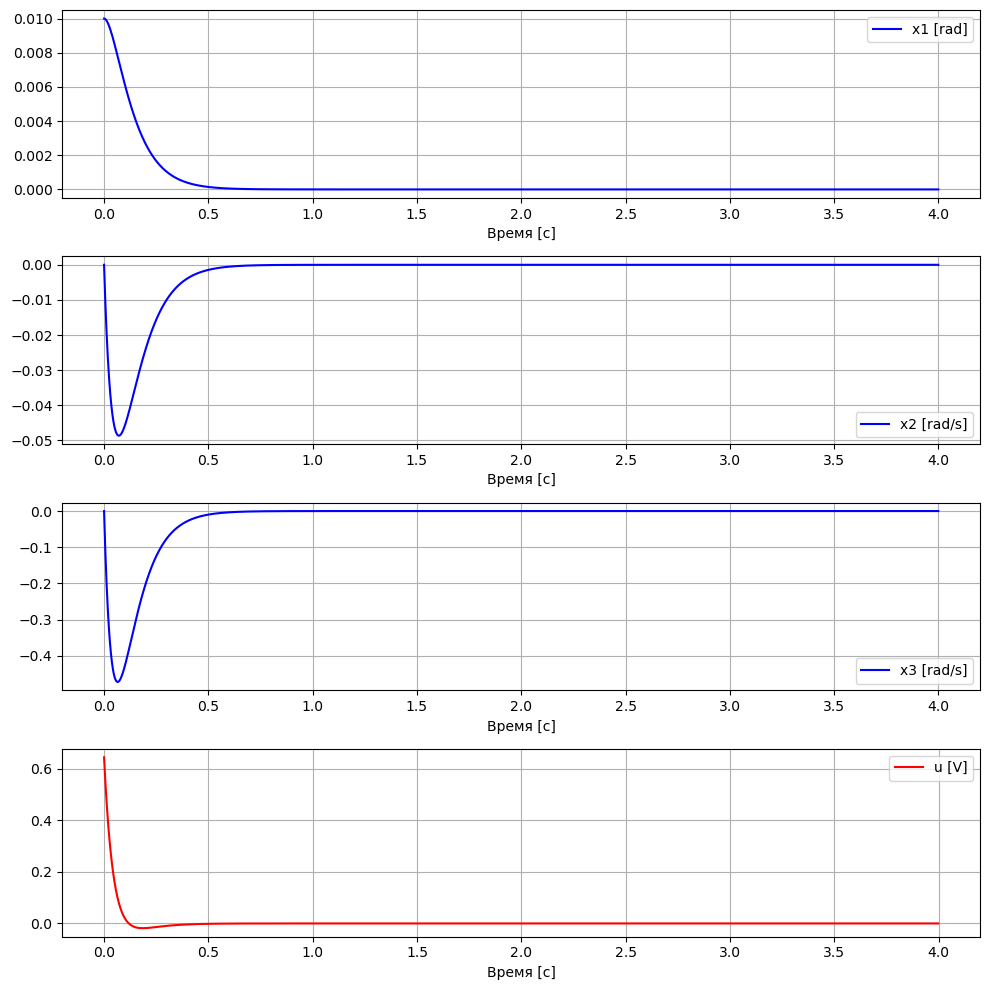

In [11]:
# State space model simulation

x0 = np.array([0.01, 0.0, 0.0])  # начальное состояние (наклон маятника)
T = np.arange(0, 4, dt)
X = [x0]
U = []

for t in T[:-1]:
    u = -K @ X[-1]
    x_next = Ad @ X[-1] + Bd.flatten() * u
    X.append(x_next)
    U.append(u)

X = np.array(X)
U = np.array(U)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]

# Visualization

plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1) 
plt.plot(T, x1, 'blue') 
plt.grid() 
plt.legend(labels=('x1 [rad]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 2) 
plt.plot(T, x2, 'blue') 
plt.grid() 
plt.legend(labels=('x2 [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 3) 
plt.plot(T, x3, 'blue') 
plt.grid() 
plt.legend(labels=('x3 [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 4) 
plt.plot(T[:-1], U, 'red') 
plt.grid() 
plt.legend(labels=('u [V]',))
plt.xlabel("Время [с]")

plt.tight_layout()
plt.show()

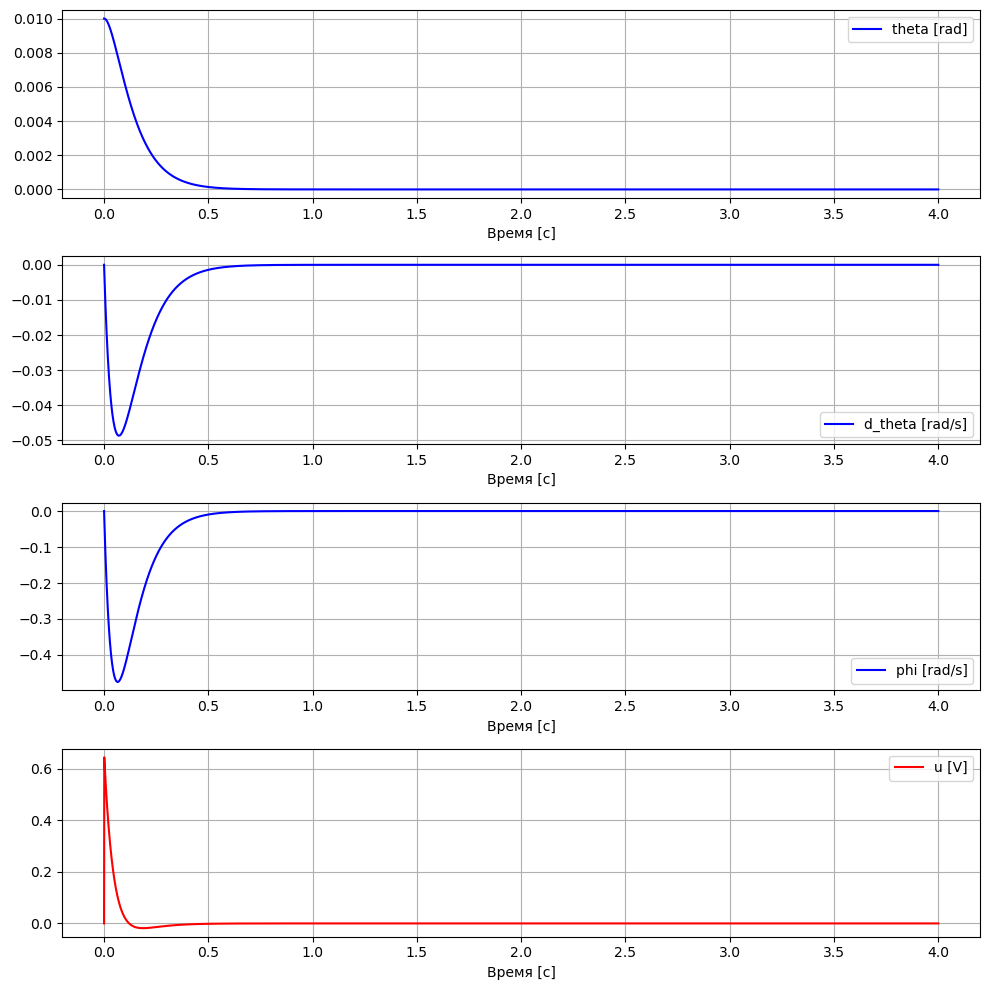

In [12]:
# Nonlinear model simulation

t0 = 0 # [s] 
t1 = 4.0 # [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
T = np.linspace(t0, t1, nt)

x0 = np.array([0.01, 0.0, 0.0]) #pend angle, pend angular vel, wheel speed
u = 0.0 # [V]

X = [x0]
U = [u]

x_cur = x0.copy()

for t in T[:-1]:
    u = -K @ x_cur
    u[0] = np.clip(u[0], -Vmax, Vmax)

    x_next = nonlinear_dynamics(x_cur[0], x_cur[1], x_cur[2], u[0])

    X.append(x_next)
    U.append(u[0])

    x_cur = x_next.copy()

X = np.array(X)
U = np.array(U)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]

# Simulated data visualization 

plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1) 
plt.plot(T, x1, 'blue') 
plt.grid() 
plt.legend(labels=('theta [rad]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 2) 
plt.plot(T, x2, 'blue') 
plt.grid() 
plt.legend(labels=('d_theta [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 3) 
plt.plot(T, x3, 'blue') 
plt.grid() 
plt.legend(labels=('phi [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(4, 1, 4) 
plt.plot(T, U, 'red') 
plt.grid() 
plt.legend(labels=('u [V]',))
plt.xlabel("Время [с]")

plt.tight_layout()
plt.show()

# Exercise
# Play with the cost function weights and check how transient responce changes its characteristics. Choose the best values.

Swing-Up Control

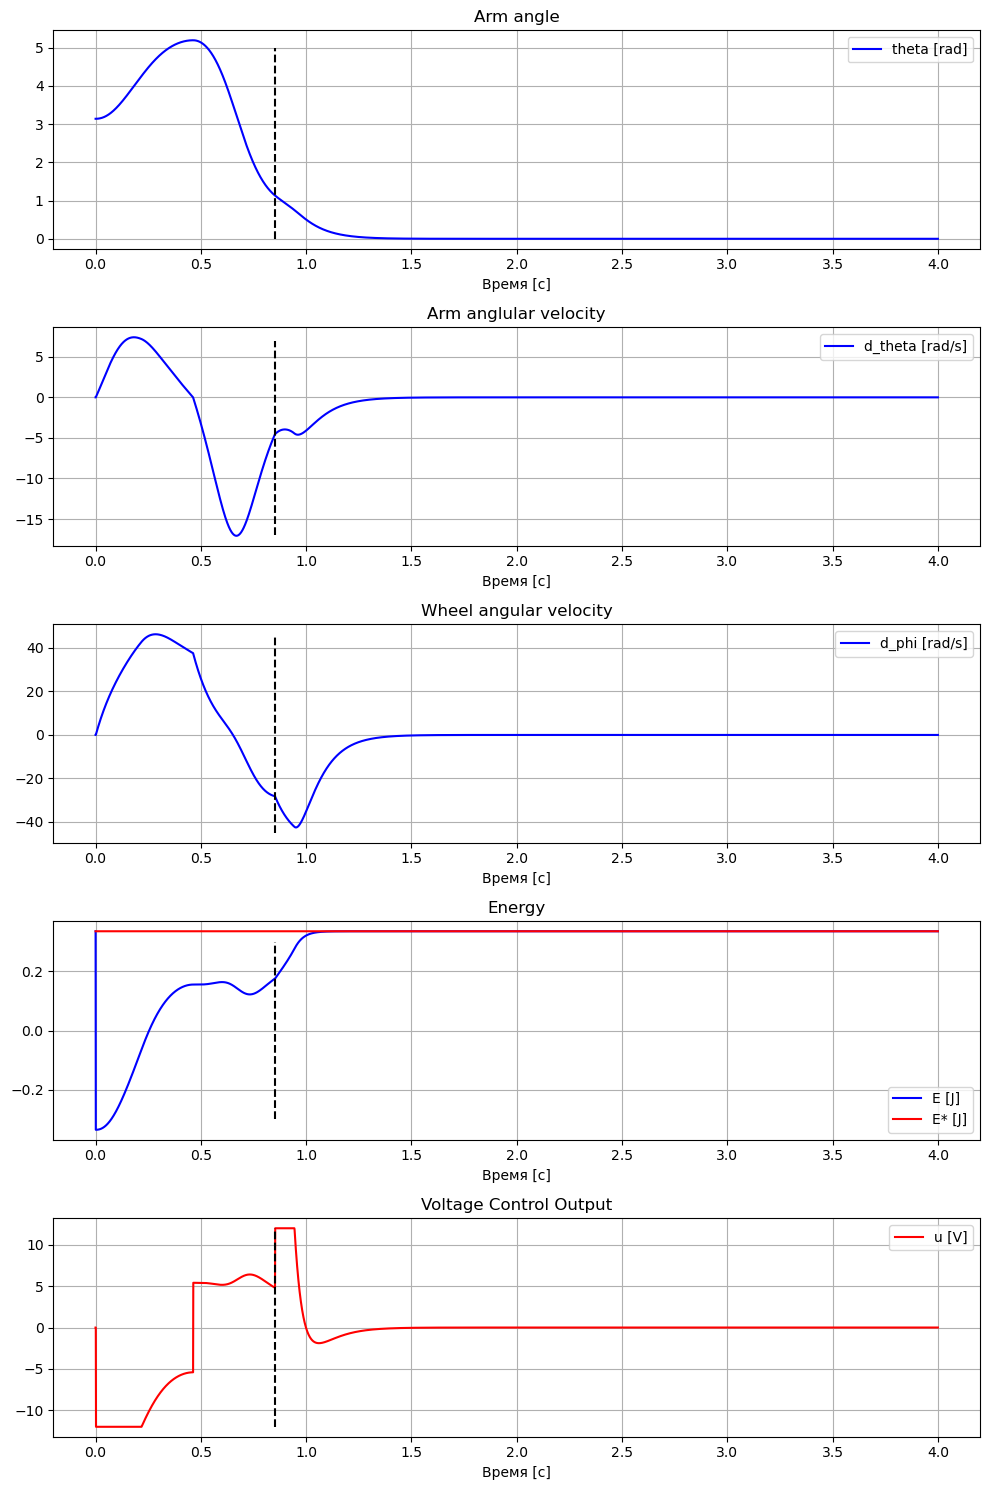

In [14]:
# Nonlinear model simulation
E_ref = (m1 * L1 + m2 * L2) * g
k = 30.0
epsilon = 0.16

t0 = 0 # [s] 
t1 = 4.0 # [s] 

nt = int(t1/dt) + 1 # Number of points of sim time
T = np.linspace(t0, t1, nt)

x0 = np.array([3.14, 0.0, 0.0]) #pend angle, pend angular vel, wheel speed
u = 0.0 # [V]
E = 0.5 * (m1 * L1**2 + m2 * L2**2 + I1 + I2) * x_cur[1]**2 + (m1 * L1 + m2 * L2) * g * np.cos(x_cur[0]) # system energy

X = [x0]
U = [u]
E_arr = [E]
E_ref_arr = [E_ref]
t_switch = 0.0

x_cur = x0.copy()

for t in T[:-1]:
    # calculate current system energy
    E = 0.5 * (m1 * L1**2 + m2 * L2**2 + I1 + I2) * x_cur[1]**2 + (m1 * L1 + m2 * L2) * g * np.cos(x_cur[0])
    # check if energy error less than threshold
    if np.abs(E_ref - E) < epsilon:
        # stabilization mode (LQR control)
        u = -K @ x_cur
        u = u[0]
        if t_switch == 0.0:
            t_switch = t
    else:
        # swing-up mode (energy-shaping control)
        u = k * (E_ref - E) * np.sign(-x_cur[1])
    u = np.clip(u, -Vmax, Vmax)

    x_next = nonlinear_dynamics(x_cur[0], x_cur[1], x_cur[2], u)

    # save data
    X.append(x_next)
    U.append(u)
    E_arr.append(E)
    E_ref_arr.append(E_ref)

    x_cur = x_next.copy()

X = np.array(X)
U = np.array(U)
E_arr = np.array(E_arr)
E_ref_arr = np.array(E_ref_arr)
x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]
e_real = E_arr[:]
e_ref = E_ref_arr[:]

# Data visualization 
plt.figure(figsize=(10, 15))

plt.subplot(5, 1, 1) 
plt.title('Arm angle')
plt.plot(T, x1, 'blue') 
plt.plot([t_switch, t_switch], [0.0, 5.0], 'black', linestyle = 'dashed')
plt.grid() 
plt.legend(labels=('theta [rad]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 2) 
plt.title('Arm anglular velocity')
plt.plot(T, x2, 'blue') 
plt.plot([t_switch, t_switch], [-17.0, 7.0], 'black', linestyle = 'dashed')
plt.grid() 
plt.legend(labels=('d_theta [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 3) 
plt.title('Wheel angular velocity')
plt.plot(T, x3, 'blue') 
plt.plot([t_switch, t_switch], [-45.0, 45.0], 'black', linestyle = 'dashed')
plt.grid() 
plt.legend(labels=('d_phi [rad/s]',))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 4) 
plt.title('Energy')
plt.plot(T, e_real, 'blue') 
plt.plot(T, e_ref, 'red') 
plt.plot([t_switch, t_switch], [-0.3, 0.3], 'black', linestyle = 'dashed')
plt.grid() 
plt.legend(labels=('E [J]', 'E* [J]'))
plt.xlabel("Время [с]")

plt.subplot(5, 1, 5) 
plt.title('Voltage Control Output')
plt.plot(T, U, 'red') 
plt.plot([t_switch, t_switch], [-12.0, 12.0], 'black', linestyle = 'dashed')
plt.grid() 
plt.legend(labels=('u [V]',))
plt.xlabel("Время [с]")

plt.tight_layout()
plt.show()

# Exercise
# Play with k gain and threshold epsilon. Check how transient responce changes its characteristics and choose the best values.